# Santander Customer Transaction Prediction

At Santander, mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Santander Bank’s data science team wants to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The bank is continually challenging its machine learning algorithms to make sure they can more accurately identify new ways to solve its most common challenges such as:

- Is a customer satisfied?
- Will a customer buy this product?
- Can a customer pay this loan?

## Problem Statement
In this project, we need to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 

They don't specify what the transaction is, so competitors truly had to rely on the data to make predictions.

## Data Overview

- Data is anonymized, meaning data has no description and no label.
  - **200** ambiguous variables named `var_0`-`var_199`. 
- Both training set and test set have 200000 rows.
- Training set have 202 features and test set have 201 features.
- One extra feature in the training set is `target` feature, which is the class of a row.
- `target` feature is binary (0 or 1), 1(transaction) and 0(no transaction)
- `ID_code` feature is the unique id of the row and it doesn't have any effect on target.
- There are no missing values in both training set and test set because the dataset is already processed.

In [0]:
# Load packages

import pandas as pd
import numpy as np

# Configure visualisations
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy import special
from scipy.stats import spearmanr

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

%matplotlib inline
plt.style.use('ggplot')

# Configure seaborn
sns.set_style('white')
sns.set_style('white',{"xtick.major.size": 5, "ytick.major.size": 5})

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 15

import warnings
warnings.filterwarnings('ignore')


In [0]:
# Functions

# Text Annotation
def text_annotate(cnt):
    for i in cnt.patches:
        height = i.get_height()
        cnt.text(i.get_x() + i.get_width()/2., height,'%d' % int(height),ha='center',va='bottom')

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(20,10,figsize=(18,35))

    for feature in features:
        i += 1
        plt.subplot(20,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)

    plt.show()

#  Outlier analysis using boxplots.
def plot_feature_boxplot(df, features):
  i = 0
  sns.set_style('whitegrid')
  plt.figure()
  fig, ax = plt.subplots(10,5,figsize=(18,24))
  for feature in features:
    i += 1
    plt.subplot(10,5,i)
    sns.boxplot(df[feature], color="lightblue")
    plt.xlabel(feature, fontsize=11)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', labelsize=6, pad=-6)
    plt.tick_params(axis='y', labelsize=6)

  plt.show()

# Checking outliers using Chauvenet's criterion.
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = scipy.special.erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

## Load Datasets

In [0]:
train = pd.read_csv("/content/train.csv.zip")
test = pd.read_csv("/content/test.csv.zip")

In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
print("Train Data Size {}\nTest Data Size {}".format(train.shape, test.shape))

Train Data Size (200000, 202)
Test Data Size (200000, 201)


In the train dataset there are 200,000 observations and 202 variables using which we have to predict the customer transaction and the test data has 200,000 observations and 201 variables.

**train contains**:
- ID_code (string)
- target
- 200 numerical variables, named from **var_0** to **var_199**

**test contains**:
- ID_code (string)
- 200 numerical variables, named from **var_0** to **var_199** 

## Distribution of the `target` variable

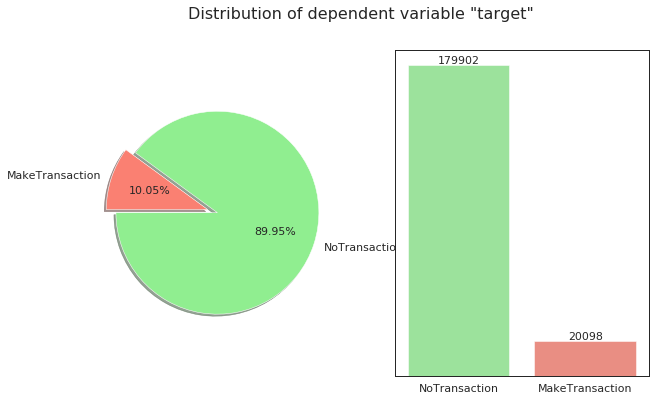

In [7]:
canMakeTransaction = {0:'No',1:'Yes'}

fig,axes=plt.subplots(1,2)
plt.suptitle('Distribution of dependent variable "target"',fontsize=16)
labels = ['NoTransaction', 'MakeTransaction']
# Pie chart
train['target'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%', ax=axes[0],
                                             labels=labels,colors=['#90EE90','#FA8072'], shadow=True, startangle=180)

axes[0].set_ylabel('')

# Bar chart
cnt = sns.countplot('target', data=train, palette=['#90EE90', '#FA8072'], ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_xticklabels(labels)
text_annotate(cnt)
plt.show()


- target variable has imbalanced class distribution where the number of observations belonging to one class is significantly lower than those belonging to the other class.
- Above visualisation shows that **89.95%** of customers who will not make the transaction (belong to "0") and only **10.05%** of customers make the transaction (belong to "1") at Santander. 

## Basic Statistics
- Standard deviation is relatively large for both train and test data.
- `min`, `max` , `mean` is nearly close to each other for train and test set.
- `mean` is largely distributed.


In [8]:
train.iloc[:,2:].describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,0.662956,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,4.068845,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,-14.545700,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.

In [9]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

### Target Distribution in Quartiles

Class 1 target distribution in feature quartiles are quite similar for each feature. Most of the class 1 target rows are either in the **1st** quartile or in the** 4th** quartile of the features because of the winsorization. Winsorization clips the extreme values, so they are grouped up in the spikes inside 1st quartile and 4th quartile.

- **94** features have highest class 1 target percentage in **1st quartile**
- **101** features have highest class 1 target percentage in **4th quartile**
- Only **5** features have highest class 1 target percetange in **2nd** and **3rd** quartile, and those features are `var_17`, `var_30`, `var_100`, `var_101`, `var_105`

Maximum class 1 target percentage for **1st quartile** is **14.35%** (**85.65%** class 0), and for **4th quartile** is **13.43%** (**86.57%** class 0). Maximum class 1 target percentage for **2nd quartile** is **10.34%** (**89.66%** class 0), and for **3rd quartile** is **10.05%** (**89.95%** class 0 target). 

To conclude, values in **1st** and **4th** quartiles have higher chance (3-4%) to be class 1 than values in **2nd** and **3rd** quartile for **195** features.

In [10]:
df_qdist = pd.DataFrame(np.zeros((200, 9)), columns=['Quartile 1 Positives', 'Quartile 2 Positives', 'Quartile 3 Positives', 'Quartile 4 Positives',
                                                     'Quartile 1 Positive Percentage', 'Quartile 2 Positive Percentage', 'Quartile 3 Positive Percentage', 'Quartile 4 Positive Percentage',
                                                     'Quartile Order'])
features = [col for col in train.columns.values.tolist() if col.startswith('var')]
quartiles = np.arange(0, 1, 0.25)
df_qdist.index = features

for i, feature in enumerate(features):
    for j, quartile in enumerate(quartiles):
        target_counts = train[np.logical_and(train[feature] >= train[feature].quantile(q=quartile), 
                                                train[feature] < train[feature].quantile(q=quartile + 0.25))].target.value_counts()
        
        ones_per = target_counts[1] / (target_counts[0] + target_counts[1]) * 100
        df_qdist.iloc[i, j] = target_counts[1]
        df_qdist.iloc[i, j + 4] = ones_per

pers = df_qdist.columns.tolist()[4:-1]         
        
for i, index in enumerate(df_qdist.index):
    order = df_qdist[pers].iloc[[i]].sort_values(by=index, ascending=False, axis=1).columns
    order_str = ''.join([col[9] for col in order])
    df_qdist.iloc[i, 8] = order_str        
                
df_qdist = df_qdist.round(2)
df_qdist.head(10)

,Quartile 1 Positives,Quartile 2 Positives,Quartile 3 Positives,Quartile 4 Positives,Quartile 1 Positive Percentage,Quartile 2 Positive Percentage,Quartile 3 Positive Percentage,Quartile 4 Positive Percentage,Quartile Order
var_0,4518.0,4472.0,4725.0,6383.0,9.04,8.94,9.45,12.77,4312
var_1,4325.0,4641.0,5093.0,6039.0,8.65,9.28,10.19,12.08,4321
var_2,4449.0,4432.0,4926.0,6291.0,8.90,8.86,9.85,12.58,4312
var_3,4850.0,4930.0,5105.0,5213.0,9.70,9.86,10.21,10.43,4321
var_4,4931.0,4937.0,4931.0,5299.0,9.86,9.87,9.86,10.60,4213
var_5,4601.0,4819.0,5011.0,5667.0,9.20,9.64,10.02,11.33,4321
var_6,4244.0,4288.0,5036.0,6530.0,8.49,8.58,10.07,13.06,4321
var_7,5140.0,4980.0,5060.0,4918.0,10.28,9.96,10.12,9.84,1324
var_8,4630.0,5043.0,5034.0,5391.0,9.26,10.09,10.07,10.78,4231
var_9,5775.0,5088.0,4902.0,4333.0,11.55,10.18,9.80,8.67,1234


In [11]:
# 5 features that doesn't have highest positive target percentage in 1st and 4th quartiles
df_qdist[np.logical_or(df_qdist['Quartile Order'].str.startswith('2'), df_qdist['Quartile Order'].str.startswith('3'))] 

,Quartile 1 Positives,Quartile 2 Positives,Quartile 3 Positives,Quartile 4 Positives,Quartile 1 Positive Percentage,Quartile 2 Positive Percentage,Quartile 3 Positive Percentage,Quartile 4 Positive Percentage,Quartile Order
var_17,4996.0,5025.0,5067.0,5010.0,9.99,10.05,10.13,10.02,3241
var_30,4982.0,5059.0,5006.0,5051.0,9.96,10.12,10.01,10.10,2431
var_100,4946.0,5104.0,5008.0,5040.0,9.89,10.21,10.02,10.08,2431
var_101,5164.0,5171.0,4836.0,4927.0,10.33,10.34,9.67,9.85,2143
var_185,5025.0,5006.0,5083.0,4983.0,10.05,10.01,10.17,9.97,3124


In [12]:
for i, col in enumerate(pers):    
  print('There are {} features that have the highest positive target percentage in Quartile {}'.format(df_qdist[df_qdist['Quartile Order'].str.startswith(str(i + 1))].count()[0], i + 1))
  print('Quartile {} max positive target percentage = {}% ({})'.format(i + 1, df_qdist[col].max(), df_qdist[col].argmax()))
  print('Quartile {} min positive target percentage = {}% ({})\n'.format(i + 1, df_qdist[col].min(), df_qdist[col].argmin()))

There are 94 features that have the highest positive target percentage in Quartile 1
Quartile 1 max positive target percentage = 14.35% (var_81)
Quartile 1 min positive target percentage = 8.49% (var_6)

There are 3 features that have the highest positive target percentage in Quartile 2
Quartile 2 max positive target percentage = 10.68% (var_149)
Quartile 2 min positive target percentage = 8.58% (var_6)

There are 2 features that have the highest positive target percentage in Quartile 3
Quartile 3 max positive target percentage = 10.46% (var_184)
Quartile 3 min positive target percentage = 8.4% (var_81)

There are 101 features that have the highest positive target percentage in Quartile 4
Quartile 4 max positive target percentage = 13.43% (var_110)
Quartile 4 min positive target percentage = 8.32% (var_34)



## Density plots of features¶
Let's show now the density plot of variables in train dataset.

We represent with different colors the distribution for values with target value 0 and 1. 

### Target Distributions in Features

Distribution of columns per target class


<Figure size 720x432 with 0 Axes>

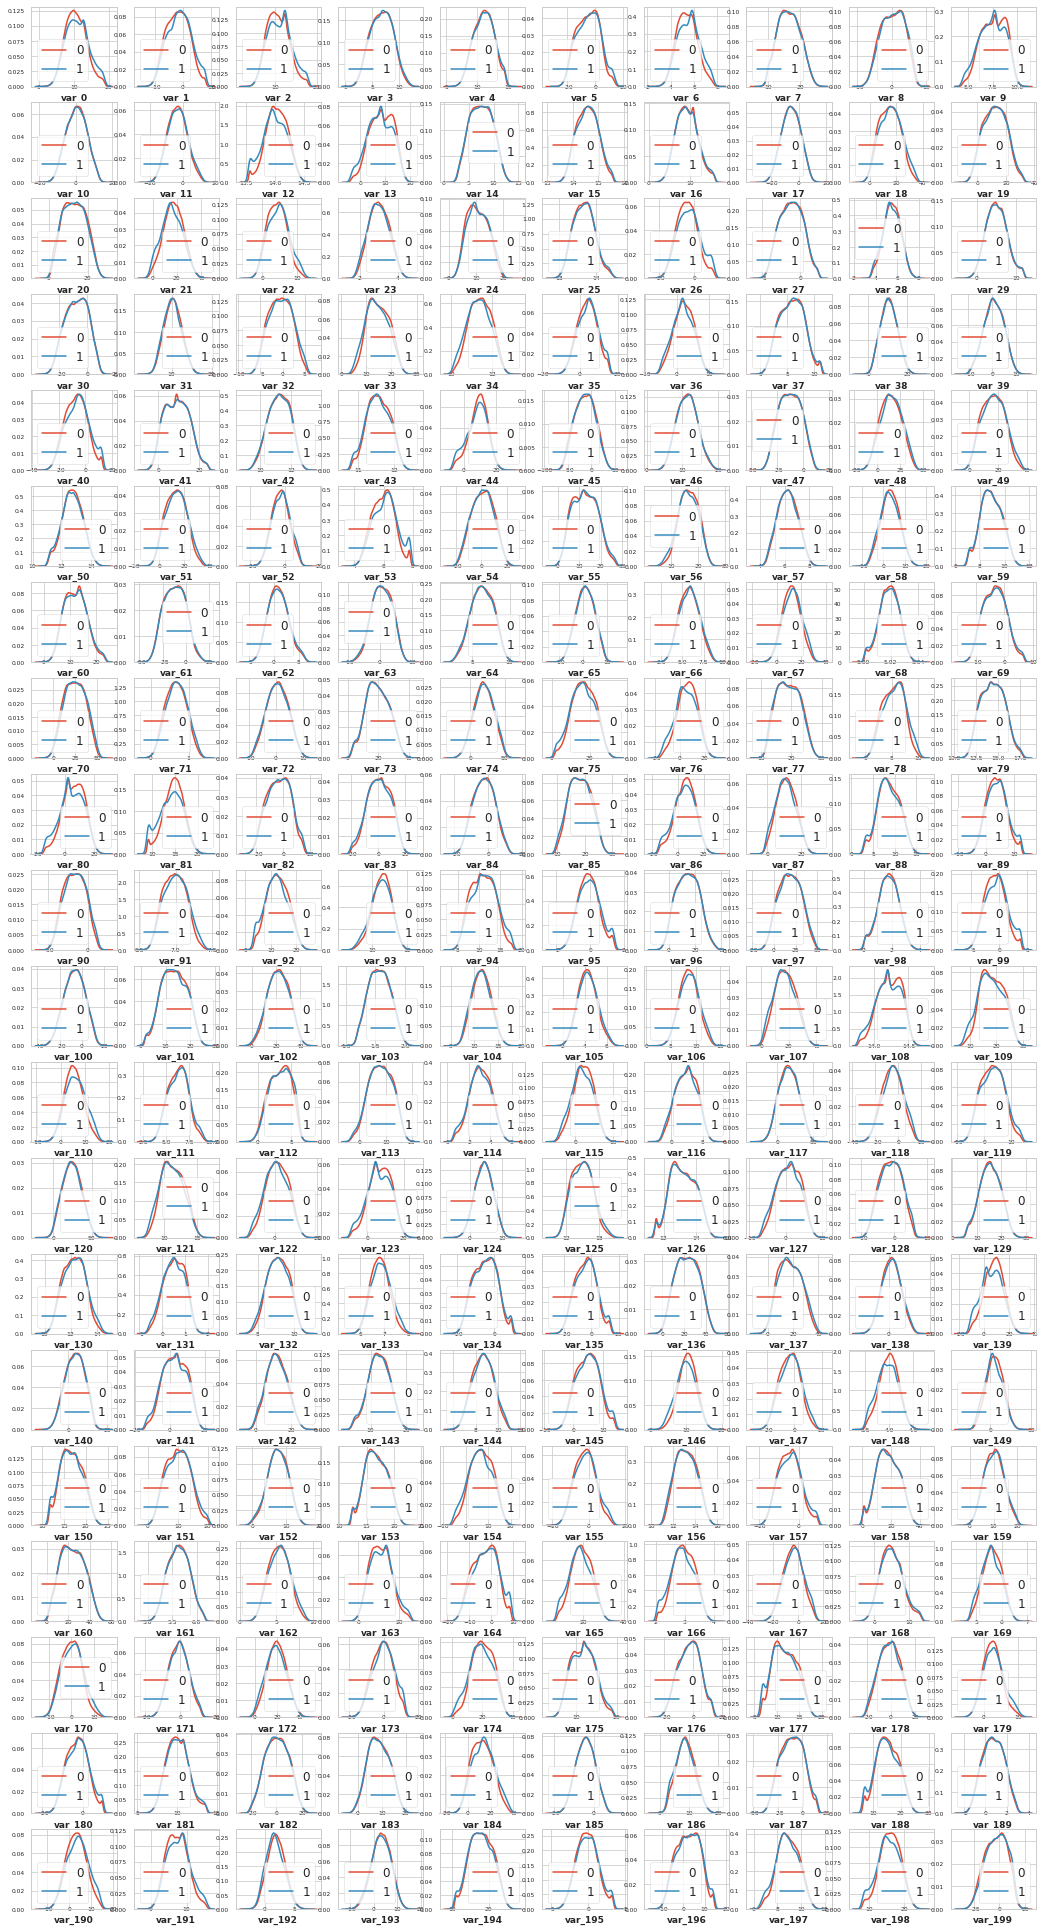

In [13]:
print("Distribution of columns per target class")
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:202]

plot_feature_distribution(t0, t1, '0', '1', features)

***The distributions of many variables can be seen either very closely, or somewhat imitating the Gaussian/Normal distribution.***

- As observed from predictor variables distribution it can be seen that considerable number of variables are following same distribution for both the classes of target variables like `var_3`, `var_4`, `var_10`, `var_11`, `var_171`, `var_185`.
- Variables like `var_0`, `var_1`, `var_2`, `var_9`, `var_180`, `var_98`. followed different distribution for both the classes of target. 
- `var_2`, `var_13`, `var_26`, `var_55`, `var_175`, `var_184`, `var_196` shows a distribution that resambles to a bivariate distribution.

### Feature Distributions in Training and Test Set
Training and test set distributions of features are not perfectly identical. There are bumps on the distribution peaks of test set because the unique value counts are lesser than training set. Distribution tails are smoother than peaks and spikes are present in both training and test set.

<Figure size 720x432 with 0 Axes>

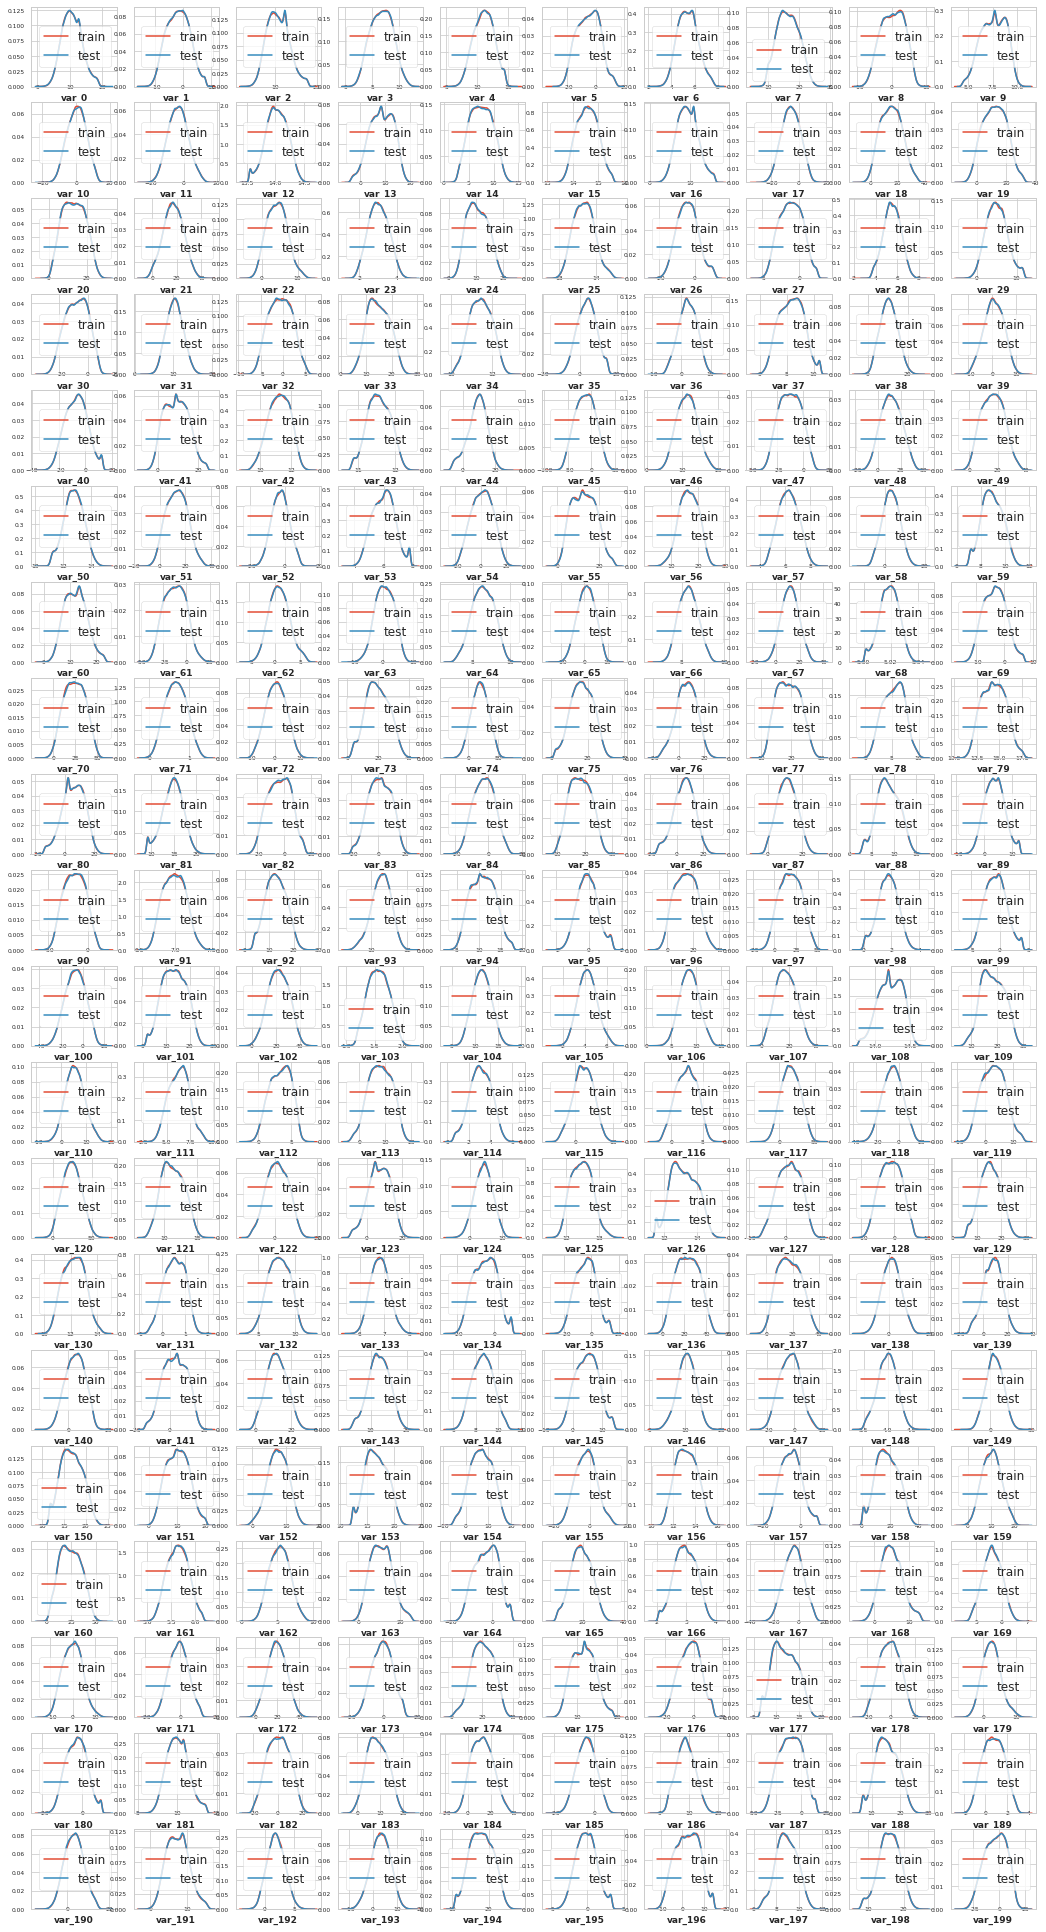

In [14]:
features = train.columns.values[2:202]
plot_feature_distribution(train, test, 'train', 'test', features)

## Distribution of mean values in both train and test dataset

Let's check now the distribution of the **mean values per row** in the train and test set.

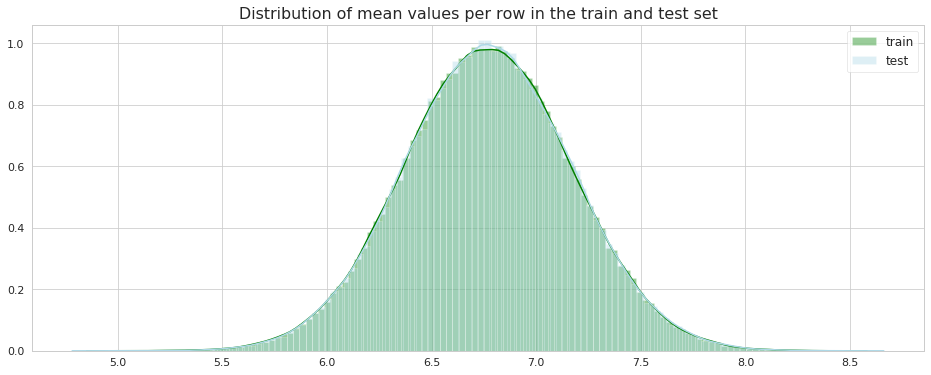

In [15]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Distribution of the **mean values per columns** in the train and test set.

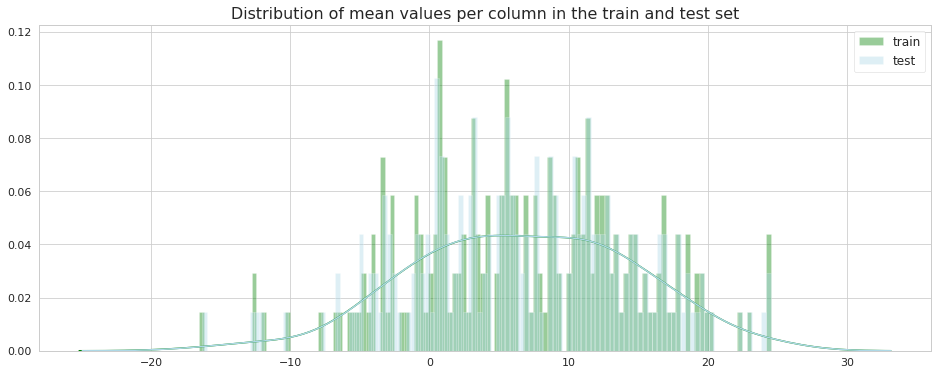

In [16]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="green",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Distribution of **standard deviation of values per row** for train and test datasets.

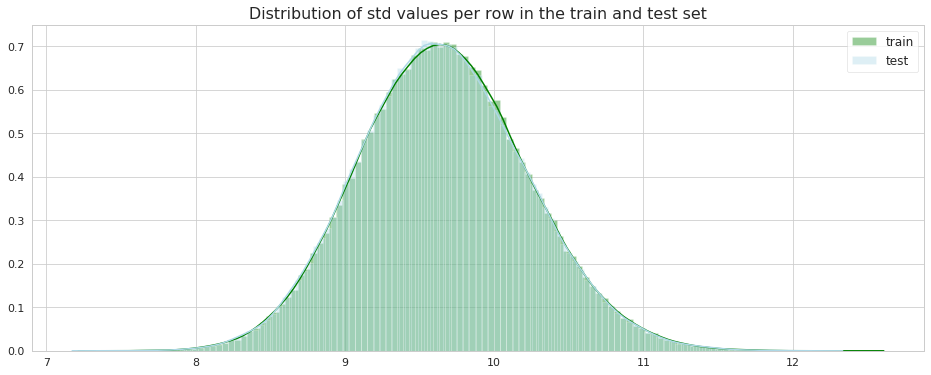

In [17]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Distribution of the **standard deviation of values per columns** in the train and test datasets.

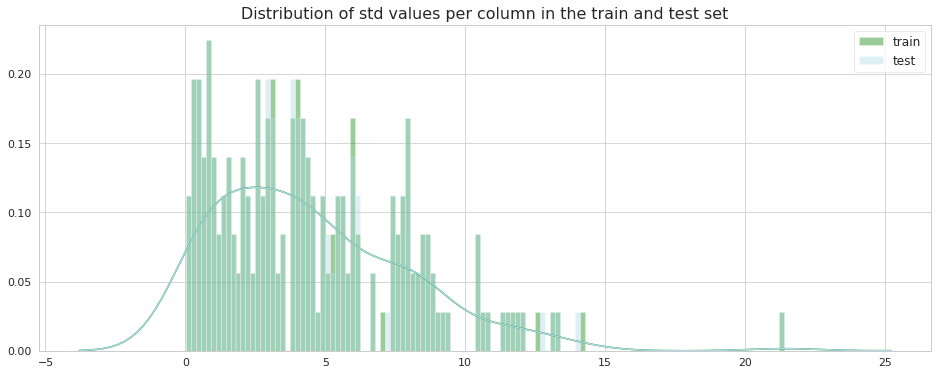

In [18]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="green",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="lightblue", kde=True,bins=120, label='test')
plt.legend(); plt.show()

Distribution of the **mean value per row** in the train dataset, `grouped by` value of `target`.

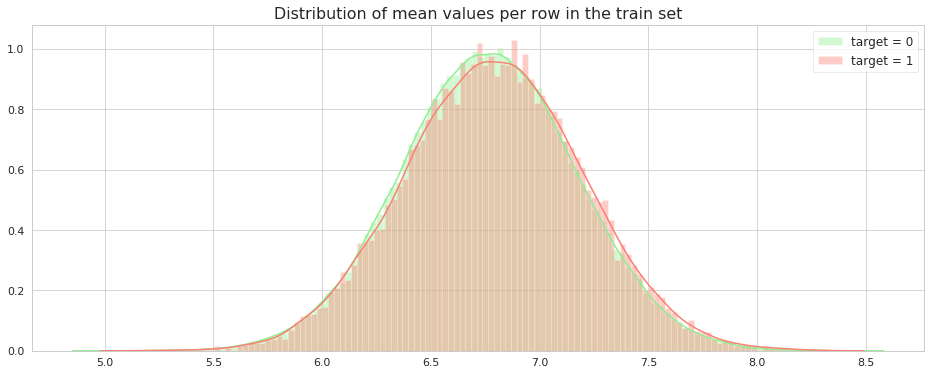

In [19]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color='#90EE90', kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color='#FA8072', kde=True,bins=120, label='target = 1')
plt.legend() 
plt.show()


Distribution of the **mean value per column** in the train dataset, `grouped by` value of `target`.

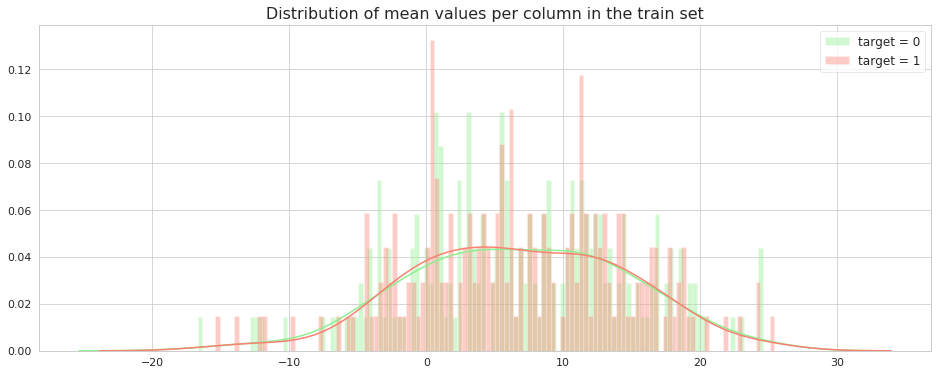

In [20]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color='#90EE90', kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color='#FA8072', kde=True,bins=120, label='target = 1')
plt.legend() 
plt.show()

## Distribution of skew and kurtosis
Let's see now what is the distribution of skew values per rows and columns.

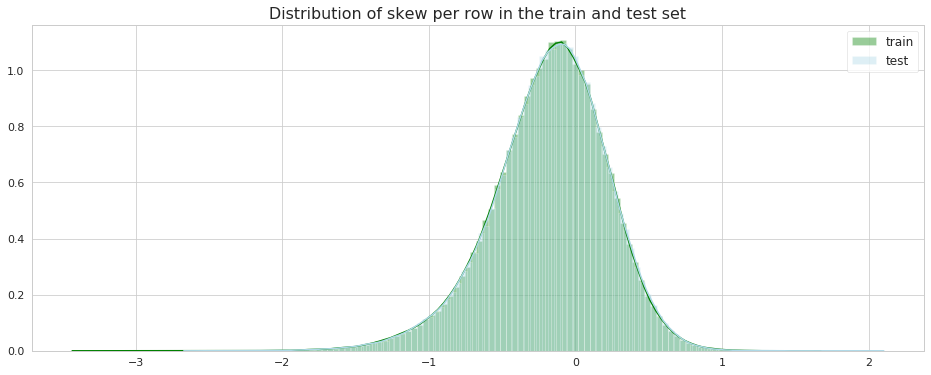

In [21]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train[features].skew(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=1),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

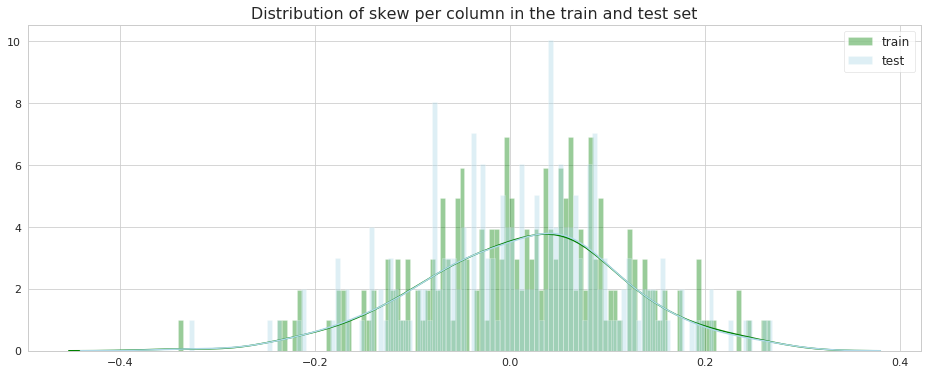

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train[features].skew(axis=0),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=0),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

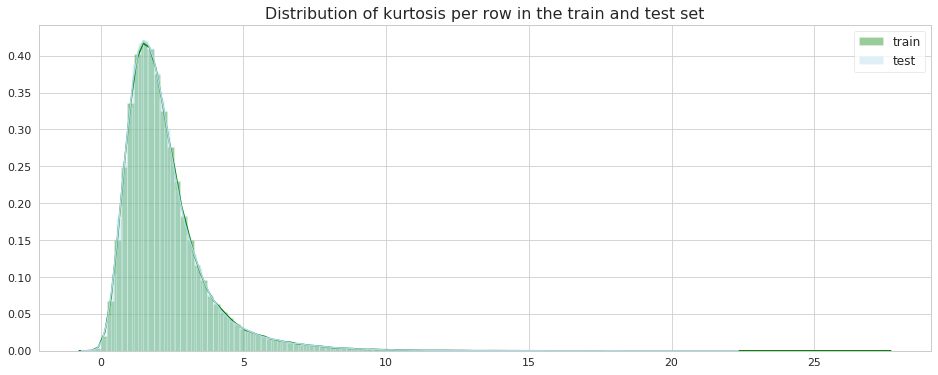

In [23]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train[features].kurtosis(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=1),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

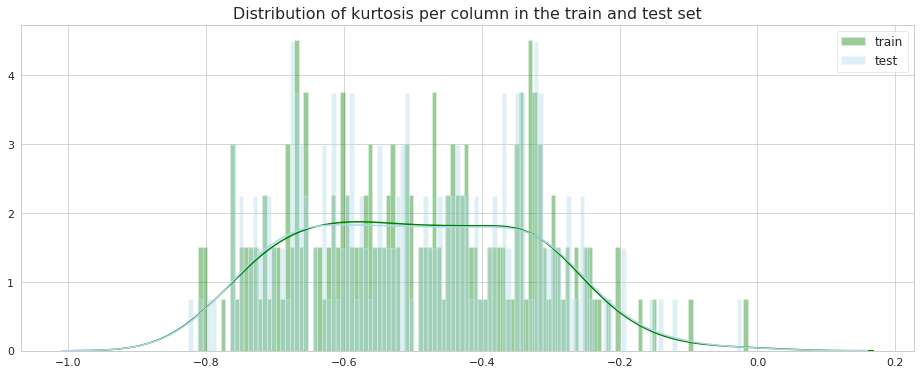

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=0),color="lightblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's see now the distribution of **skewness on rows** in train separated for values of **target** `0` and `1`.

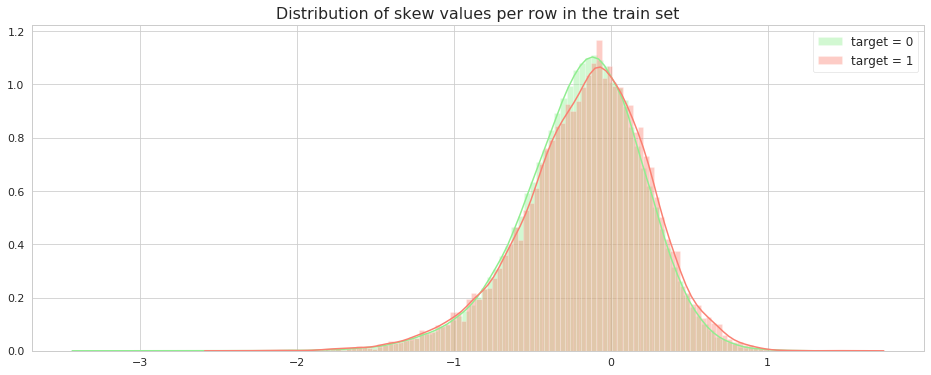

In [25]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color='#90EE90', kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color='#FA8072', kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Let's see now the distribution of **skewness on columns** in train separated for values of **target** `0` and `1`.

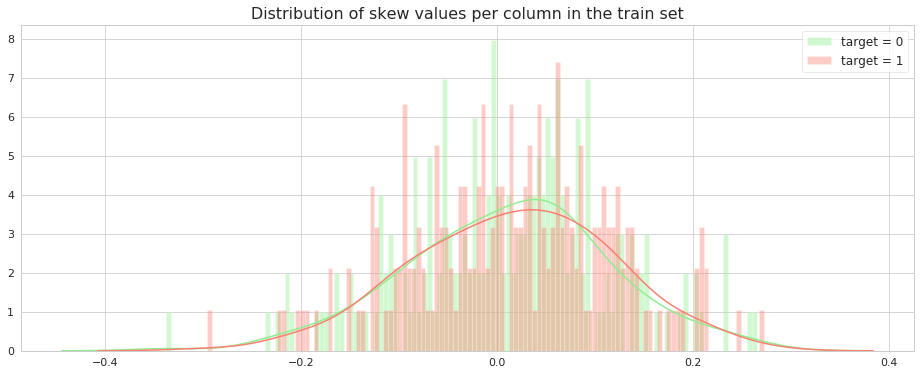

In [26]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color='#90EE90', kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color='#FA8072', kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Let's see now the distribution of **kurtosis on rows** in train separated for values of **target** `0` and `1`.

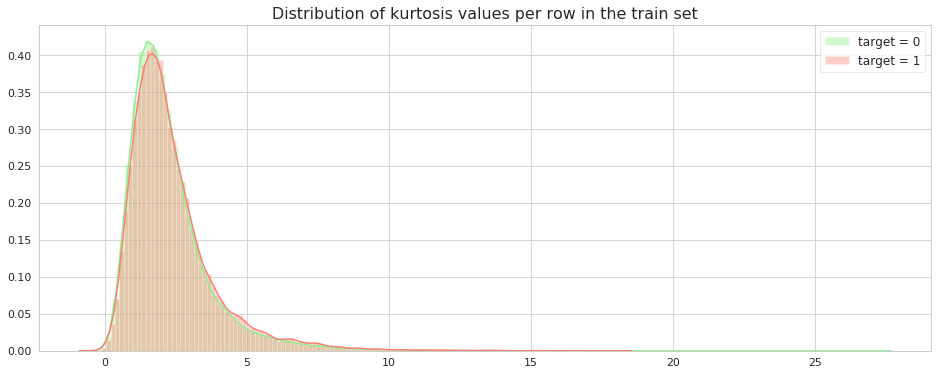

In [27]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color='#90EE90', kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color='#FA8072', kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Let's see now the distribution of **kurtosis on columns** in train separated for values of **target** `0` and `1`.

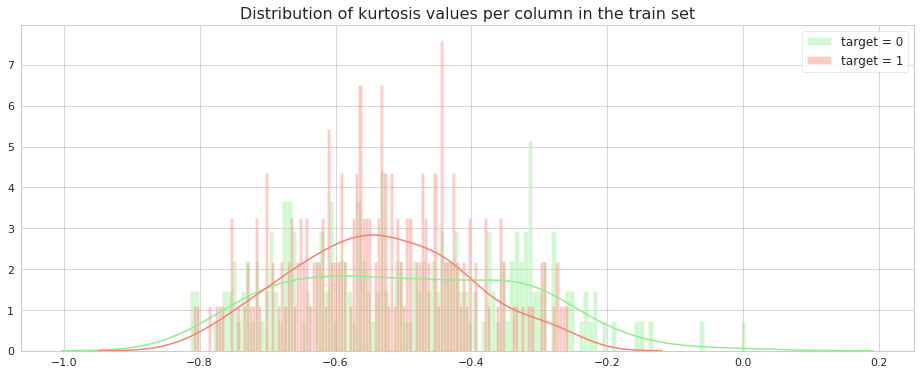

In [28]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color='#90EE90', kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color='#FA8072', kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Standard deviation is relatively large for both training and test variable data. However, the `min`, `max`, `mean`, `median`, `standard deviation` values for training and test data looks quite close. Mean values are distributed over a large range. Moreover, mean and median have similar distribution. Both training and test data is Leptokurtic and negatively skewed.

In [29]:
# target variable skewness and kurtosis
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


## Missing value 
In statistics, missing data, or missing values, occur when no data value is stored for the variable in an observation. Missing data are a common occurrence and can have a significant effect on the conclusions that can be drawn from the data. If missing values are present in the data, then according to the percentage of missing we can either delete the variable or impute the values using `mean`, `median` and `KNN imputation method`. Missing value analysis is done on both train and test dataset. 

***After the analysis, it was found that there were `no missing values` in both train and test data.*** 

In [30]:
print (train.isnull().sum().sum())
print (test.isnull().sum().sum()) 

0
0


## Outliers
Outliers are extreme values that deviate from other observations on data, they may indicate a variability in a measurement or experimental errors. In other words, an outlier is an observation that diverges from an overall pattern on a sample. 

Outlier analysis on train data using box plots is shown in below. For only `var_0` to `var_49` variables. 

<Figure size 720x432 with 0 Axes>

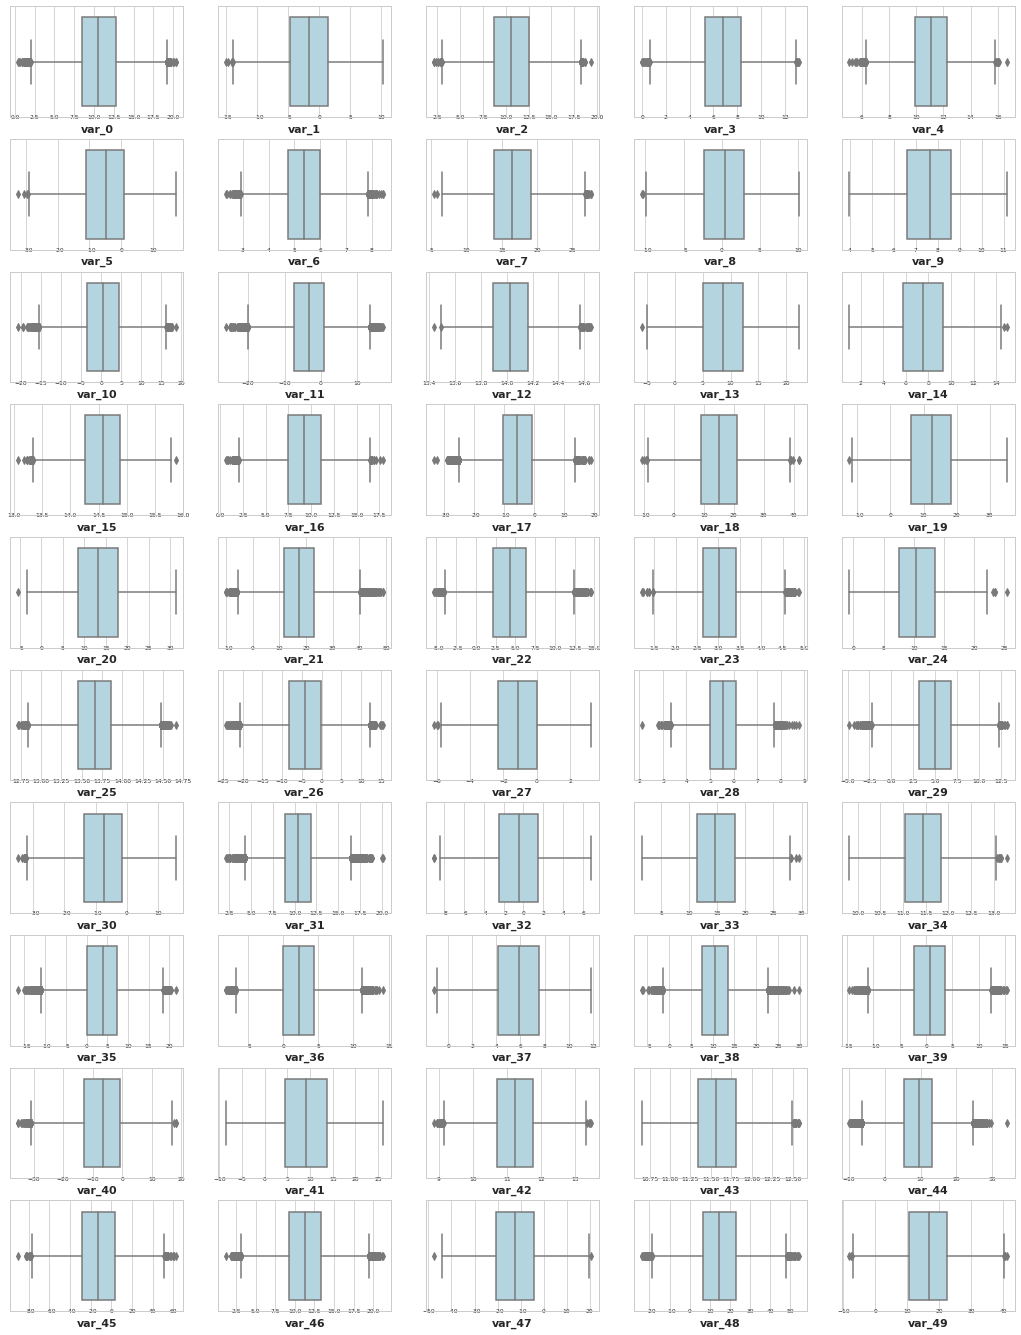

In [31]:
features = train.columns.values[2:52]
plot_feature_boxplot(train, features)


- As from the boxplots it is clear that almost all the variables have outliers.
- Outliers present in our data, are meaningful and contains important information so they can’t be removed.

Text(0.5, 0, 'Number of outliers')

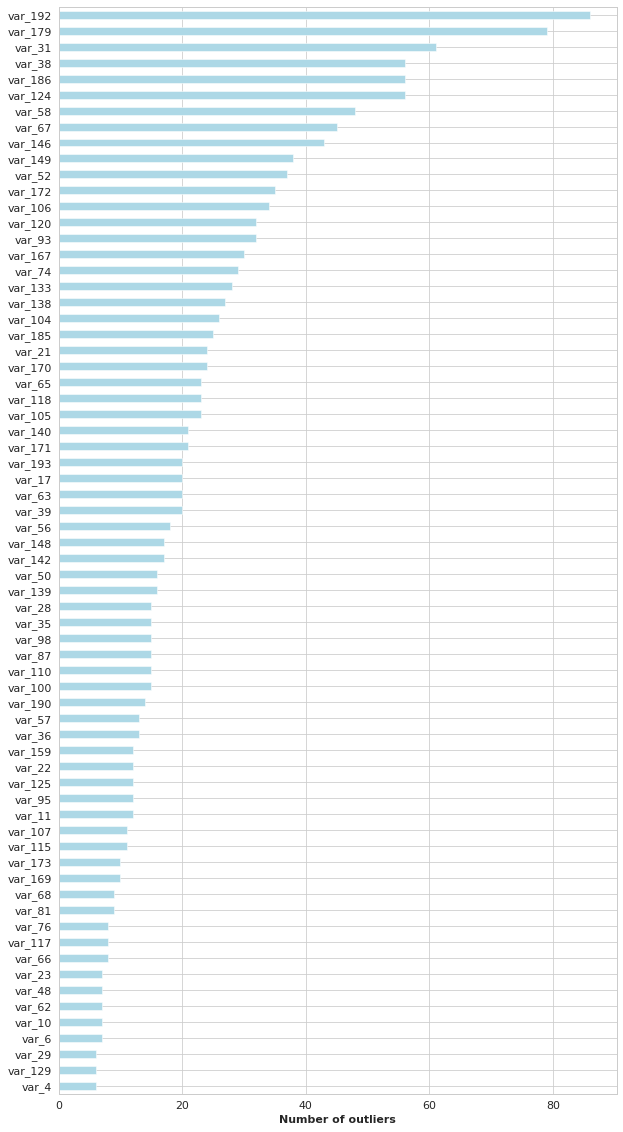

In [32]:
numerical_features=train.columns[2:]

# Outliers in each variable in train data 
train_outliers = dict()
for col in [col for col in numerical_features]:
    train_outliers[col] = train[chauvenet(train[col].values)].shape[0]
train_outliers = pd.Series(train_outliers)

train_outliers[train_outliers > 5].sort_values().plot(figsize=(10, 20), kind='barh', color='lightblue').set_xlabel('Number of outliers')

In [33]:
print('Total number of outliers in training set: {} ({:.2f}%)'.format(sum(train_outliers.values), 
                                                                      (sum(train_outliers.values) / train.shape[0]) * 100))

Total number of outliers in training set: 1740 (0.87%)


Text(0.5, 0, 'Number of outliers')

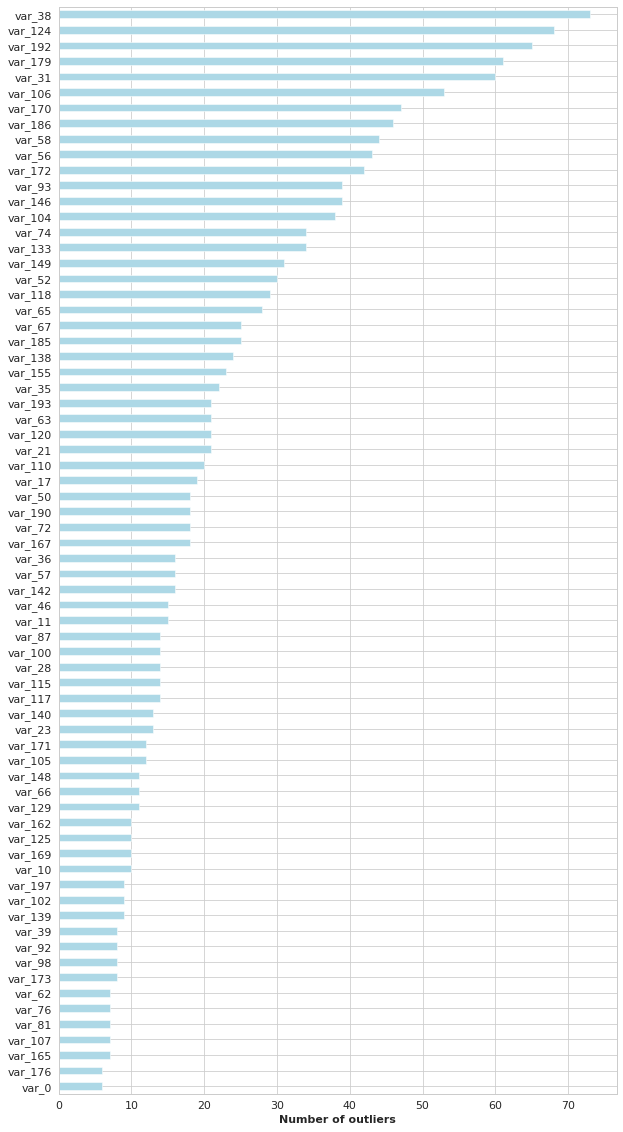

In [34]:
# Outliers in each variable in test data 
test_outliers = dict()
for col in [col for col in numerical_features]:
    test_outliers[col] = test[chauvenet(test[col].values)].shape[0]
test_outliers = pd.Series(test_outliers)

test_outliers[test_outliers > 5].sort_values().plot(figsize=(10, 20), kind='barh', color='lightblue').set_xlabel('Number of outliers')


In [35]:
print('Total number of outliers in testing set: {} ({:.2f}%)'.format(sum(test_outliers.values), 
                                                                     (sum(test_outliers.values) / test.shape[0]) * 100))

Total number of outliers in testing set: 1748 (0.87%)


## Duplicate values
Let's now check how many duplicate values exists per columns.

In [36]:
# Top 15 max of duplicate values per train set.

features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))


,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [37]:
# Top 15 number of duplicates values per test set.

np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


Same columns in train and test set have the same or very close number of duplicates of same or very close values.

## Unique values
- The lowest unique value count belongs to `var_68` which has only **451** unique values in training set and **428** unique values in test set. 451 and 428 unique values in 200,000 rows are too less that `var_68` could even be a categorical feature. 
- The highest unique value count belongs to `var_45` which has **169,968** unique values in the training set and **92,058** unique values in the test set. 
- Every feature in training set have higher unique value counts compared to features in test set.
- When the unique value count of a feature increases, the difference between training set unique value count and test set unique value count also increases.

In [0]:
train_unique = train.agg(['nunique']).transpose().sort_values(by='nunique')
test_unique = test.agg(['nunique']).transpose().sort_values(by='nunique')
uniques = train_unique.drop('target').reset_index().merge(test_unique.reset_index(), how='left', right_index=True, left_index=True)
uniques.drop(columns=['index_y'], inplace=True)
uniques.columns = ['Feature', 'Training Set Unique Count', 'Test Set Unique Count']

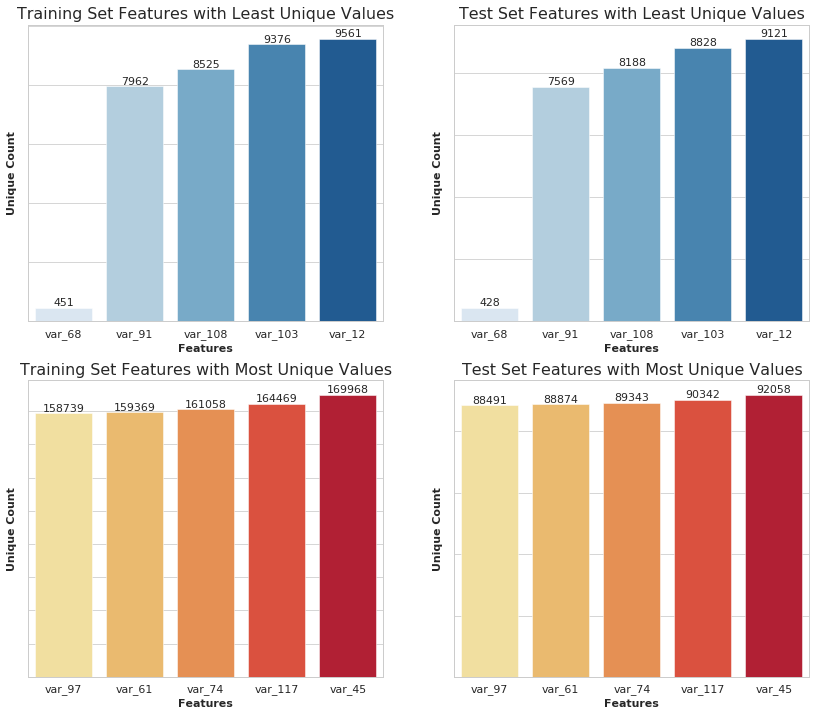

In [39]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 12))

# Least Unique        
trleast_unique = sns.barplot(x=train_unique.index[1:6], y="nunique", data=train_unique[1:].head(), ax=axs[0][0], palette="Blues")
teleast_unique = sns.barplot(x=test_unique.index[:5], y="nunique", data=test_unique.head(), ax=axs[0][1], palette="Blues")
text_annotate(trleast_unique)
text_annotate(teleast_unique)
axs[0][0].set_title('Training Set Features with Least Unique Values')
axs[0][1].set_title('Test Set Features with Least Unique Values')

# Most Unique
trmost_unique = sns.barplot(x=train_unique.index[-6:-1], y="nunique", data=train_unique[-6:-1].tail(), ax=axs[1][0], palette="YlOrRd")
temost_unique = sns.barplot(x=test_unique.index[-6:-1], y="nunique", data=test_unique[-6:-1].tail(), ax=axs[1][1], palette="YlOrRd")
text_annotate(trmost_unique)
text_annotate(temost_unique)
axs[1][0].set_title('Training Set Features with Most Unique Values')
axs[1][1].set_title('Test Set Features with Most Unique Values')


for i in range(2):
    for j in range(2):        
        axs[i][j].set(xlabel='Features', ylabel='Unique Count')
        axs[i][j].set_yticklabels('')

plt.show()


## Correlation analysis 
Correlation is a technique for investigating the linear relationship between two quantitative, continuous variables.

**Correlations**
- Features from `var_0` to `var_199` have extremely low correlation between each other in both training set and test set. 
- The *lowest correlation* between variables is `2.7e-8` and it is in the training set (between var_191 and var_75).
- The *highest correlation* between variables is `0.00986` and it is in the test set (between var_139 and var_75). 
- `target` has slightly higher correlations with other features. 
- The highest correlation between a feature and target is 0.08 (between var_81 and target).

In [0]:
# Correlation analysis on train attributes 
train_corr = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
train_corr.drop(train_corr.iloc[1::2].index, inplace=True)
train_corr_nd = train_corr.drop(train_corr[train_corr['Correlation Coefficient'] == 1.0].index)

# Correlation analysis on test attributes 
test_corr = test.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
test_corr.drop(test_corr.iloc[1::2].index, inplace=True)
test_corr_nd = test_corr.drop(test_corr[test_corr['Correlation Coefficient'] == 1.0].index)

In [41]:
# Top 5 Highest Correlations in the Training Set
train_corr_nd.tail()

,Feature 1,Feature 2,Correlation Coefficient
40190,var_110,target,0.064275
40192,var_6,target,0.066731
40194,var_12,target,0.069489
40196,target,var_139,0.074080
40198,target,var_81,0.080917


- Numerical analysis has given results of correlation values of less than (<0.005) in both train and test variables indicating the independence of predictor variables.

In [42]:
# Top 5 Highest Correlations between variables in the Training Set
train_corr_nd[np.logical_and(train_corr_nd['Feature 1'] != 'target', train_corr_nd['Feature 2'] != 'target')].tail()

,Feature 1,Feature 2,Correlation Coefficient
39868,var_183,var_189,0.009359
39870,var_81,var_174,0.009490
39872,var_165,var_81,0.009714
39874,var_53,var_148,0.009788
39876,var_139,var_26,0.009844


In [43]:
# Top 5 Highest Correlations in the Test Set
test_corr_nd.tail()

,Feature 1,Feature 2,Correlation Coefficient
39790,var_122,var_164,0.008513
39792,var_164,var_2,0.008614
39794,var_31,var_132,0.008714
39796,var_96,var_143,0.008829
39798,var_139,var_75,0.009868


In [44]:
numerical_features = train.columns.values[2:202]

# Compute the correlation matrix
corr = train[numerical_features].corr()
np.fill_diagonal(corr.values,np.nan)
corr.max().max(),corr.min().min()

(0.009713658349534146, -0.009844361358419677)

Now checking correlation among numerical variables, `minimum` and `maximum` correlation among numerical variables in train data are -0.009844 and 0.009714 respectively. This shows that the correlations between the numerical data are close to zero. That means that most of the numerical data are almost uncorrelated to each other.

### Correlation Coefficient Plot
As there are no missing values in the dataset and all the features are numberic let's try the correlation plot and see how the features are correlated to each other.

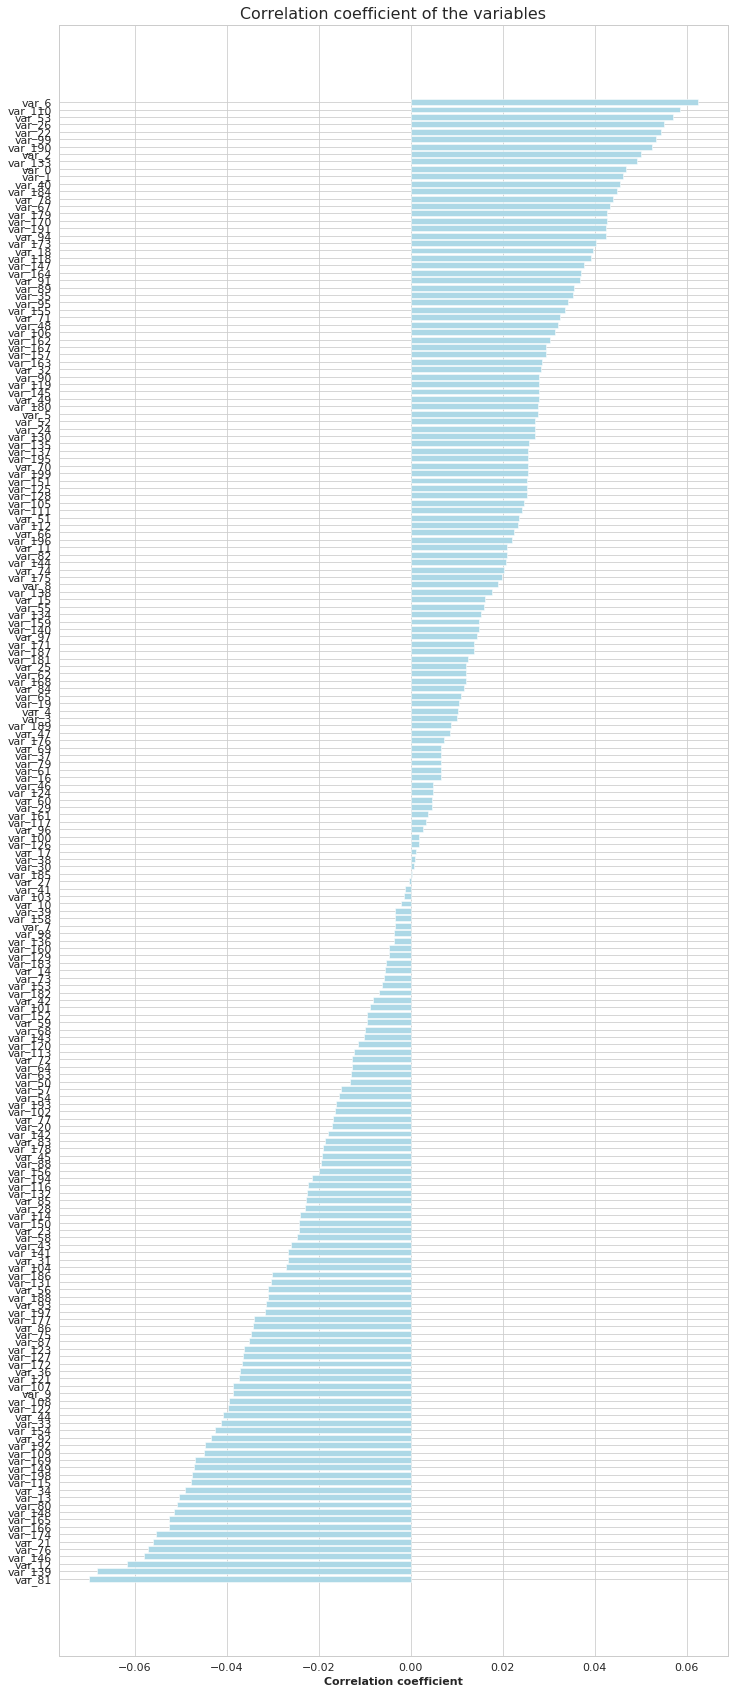

In [45]:
labels = []
values = []
for col in train.columns:
    if col not in ["ID_code", "target"]:
        labels.append(col)
        values.append(spearmanr(train[col].values, train["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='lightblue')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

The correlation coefficient values are very low and the maximum value is around 0.08 in negative side of the plot, with respect to positive side the maximum value is around 0.07.

Overall, the correlation of the features with respect to `target` are *very low*.

So, We will take some of the features which has high correlation values and plot the heatmap for further analysis.

In [46]:
corr_df_sel = corr_df.ix[(corr_df['corr_values'] < -0.05) | (corr_df['corr_values']>0.05)]
corr_df_sel

,col_labels,corr_values
81,var_81,-0.070028
139,var_139,-0.068302
12,var_12,-0.061740
146,var_146,-0.058021
76,var_76,-0.057121
21,var_21,-0.056128
174,var_174,-0.055400
166,var_166,-0.052646
165,var_165,-0.052636
148,var_148,-0.051591


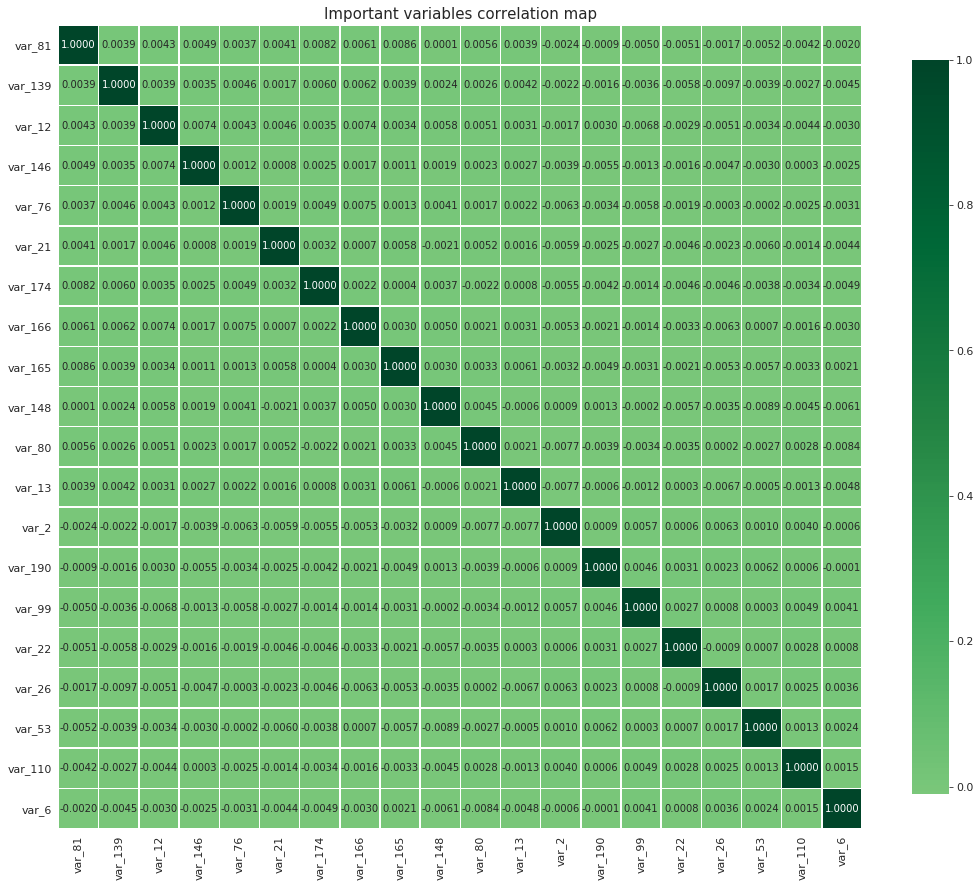

In [47]:
cols_to_use = corr_df.ix[(corr_df['corr_values'] < -0.05) | (corr_df['corr_values'] > 0.05)].col_labels.tolist()

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(18, 15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, cmap='YlGn', annot=True, vmax=1,center=0, square=True,fmt='.4f', 
            linewidths=.5, annot_kws={'size': 10}, cbar_kws={'shrink': .9})
plt.title("Important variables correlation map", fontsize=15)
plt.show()